## Effect of Pretext Training Time on Downstream Performance

How long should we pretrain on our pretext task? Does longer pretraining time always lead to better performance or is there a problem with overfitting?

To better understand this problem we will train a network on image inpainting for:

- 5 epochs
- 15 epochs
- 25 epochs
- 50 epochs

We will then compare their downstream performance.

In [1]:
import gc
import json
import torch
import numpy as np

from config import config
from RandomCutout import RandomCutout, PILImageInput

from fastai2.basics import *
from fastai2.vision.all import *

from torch.nn import MSELoss
from functools import partial

In [2]:
# Default parameters
lr=config['lr']
size=config['size']
sqrmom=config['sqrmom']
mom=config['mom']
eps=config['eps']
epochs=config['epochs']
bs=config['bs']
opt=config['opt']
sh=config['sh']
sa=config['sa']
sym=config['sym']
beta=config['beta']
act_fn=config['act_fn']
fp16=config['fp16']
pool=config['pool']
runs=config['runs']

model = config['model']

if   opt=='adam'  : opt_func = partial(Adam, mom=mom, sqr_mom=sqrmom, eps=eps)
elif opt=='rms'   : opt_func = partial(RMSProp, sqr_mom=sqrmom)
elif opt=='sgd'   : opt_func = partial(SGD, mom=mom)
elif opt=='ranger': opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)
    
size = 128
bs = 64
runs=3

In [3]:
print("lr", lr)
print("size", size)
print("sqrmom", sqrmom)
print("mom", mom)
print("eps", eps)
print("epochs", epochs)
print("bs", bs)
print("opt", opt)
print("sh", sh)
print("sa", sa)
print("sym", sym)
print("beta", beta)
print("act_fn", act_fn)
print("fp16", fp16)
print("pool", pool)
print("runs", runs)
print("model", model)

lr 0.008
size 128
sqrmom 0.99
mom 0.9
eps 1e-06
epochs 15
bs 64
opt ranger
sh 0.0
sa 0
sym 0
beta 0.0
act_fn <class 'fastai2.layers.Mish'>
fp16 0
pool <function MaxPool at 0x7f7159ca2ef0>
runs 3
model <function xresnet34 at 0x7f7159ab1950>


In [4]:
def get_dbunch(size, bs):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5), RandomCutout]
    batch_tfms=[RandomErasing(p=0.9, max_count=3, sh=sh), Normalize] if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock(cls=PILImageInput), ImageBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, 
                       get_y=lambda o: o,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)

    workers = min(8, num_cpus())
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [5]:
dbunch = get_dbunch(size, bs)
#CHANGE: We're predicting pixel values, so we're just going to predict an output for each RGB channel
dbunch.vocab = ['R', 'G', 'B']

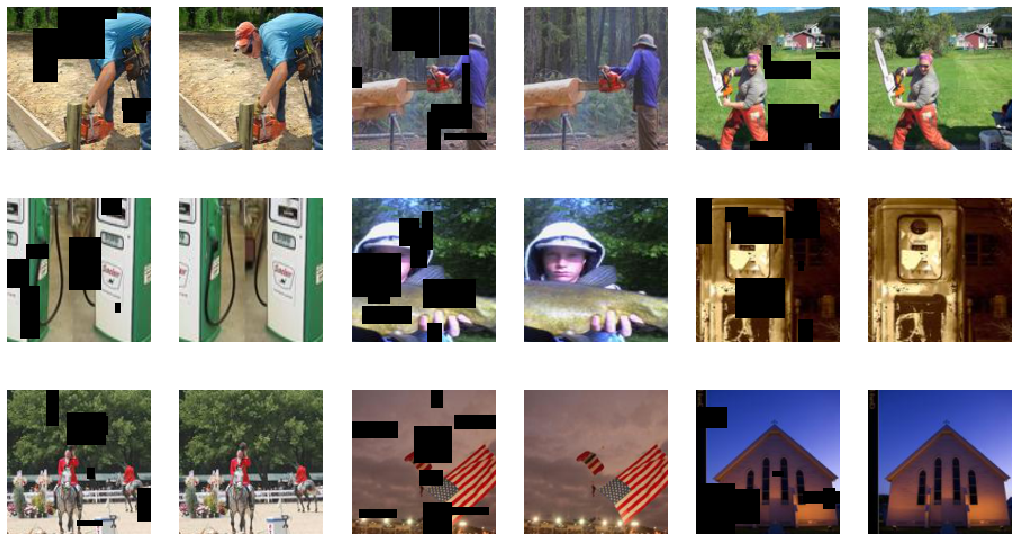

In [6]:
dbunch.show_batch()

## Pretext Task

### 5 Epochs

In [7]:
epochs = 5

In [8]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), '{}_epochs_{}.pth'.format(epochs, run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.184062,0.082859,01:44
1,0.010328,0.006040,01:36
2,0.006157,0.005084,01:36
3,0.005754,0.005398,01:35
4,0.004974,0.003861,01:36


epoch,train_loss,valid_loss,time
0,0.185014,0.077397,01:37
1,0.010398,0.006491,01:38
2,0.006019,0.009818,01:37
3,0.005812,0.010399,01:35
4,0.005157,0.003914,01:35


epoch,train_loss,valid_loss,time
0,0.185279,0.078132,01:35
1,0.010482,0.004886,01:35
2,0.006027,0.006949,01:35
3,0.005898,0.005540,01:35
4,0.005169,0.003920,01:35


### 15 Epochs

In [9]:
epochs = 15

In [10]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), '{}_epochs_{}.pth'.format(epochs, run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.185674,0.074469,01:35
1,0.010305,0.004785,01:35
2,0.006199,0.004832,01:35
3,0.006144,0.042176,01:35
4,0.005591,0.004812,01:35
5,0.005319,0.003869,01:35
6,0.005128,0.004144,01:35
7,0.005111,0.004182,01:35
8,0.004815,0.004531,01:35
9,0.004937,0.004063,01:35


epoch,train_loss,valid_loss,time
0,0.185795,0.093406,01:35
1,0.010284,0.005198,01:35
2,0.006174,0.004678,01:35
3,0.005949,0.004742,01:35
4,0.005544,0.004991,01:35
5,0.005316,0.004052,01:35
6,0.005129,0.004281,01:35
7,0.005001,0.004070,01:35
8,0.004854,0.004068,01:35
9,0.004791,0.003814,01:35


epoch,train_loss,valid_loss,time
0,0.184887,0.079392,01:35
1,0.010316,0.004983,01:35
2,0.005939,0.005925,01:35
3,0.005769,0.005370,01:35
4,0.005516,0.004542,01:35
5,0.005589,0.004177,01:35
6,0.005128,0.004126,01:35
7,0.004919,0.004212,01:35
8,0.004805,0.004191,01:35
9,0.004837,0.003954,01:35


### 25 Epochs

In [11]:
epochs = 25

In [12]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), '{}_epochs_{}.pth'.format(epochs, run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.185467,0.073256,01:35
1,0.010208,0.005181,01:35
2,0.006211,0.005348,01:35
3,0.005814,0.005504,01:35
4,0.005365,0.005051,01:35
5,0.005141,0.004032,01:35
6,0.005149,0.004244,01:35
7,0.005013,0.003927,01:35
8,0.004887,0.004185,01:35
9,0.004858,0.004375,01:35


epoch,train_loss,valid_loss,time
0,0.185383,0.067730,01:35
1,0.010311,0.006177,01:35
2,0.005960,0.004972,01:35
3,0.005798,0.008178,01:35
4,0.005448,0.004551,01:35
5,0.005351,0.004108,01:35
6,0.005463,0.004247,01:35
7,0.005222,0.004067,01:35
8,0.004928,0.004026,01:35
9,0.004783,0.004381,01:35


epoch,train_loss,valid_loss,time
0,0.185126,0.062105,01:35
1,0.010267,0.006072,01:35
2,0.006096,0.005204,01:35
3,0.005758,0.004727,01:35
4,0.005486,0.005396,01:35
5,0.005242,0.004090,01:35
6,0.005146,0.005424,01:35
7,0.005030,0.004174,01:35
8,0.004941,0.003992,01:35
9,0.005043,0.004312,01:35


### 50 Epochs

In [13]:
epochs = 50

In [14]:
for run in range(runs):
    learn = unet_learner(dbunch, model, pretrained=False, opt_func=opt_func, metrics=[], loss_func=MSELoss())

    if fp16: learn = learn.to_fp16()
    cbs = []
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    #Save model backbone
    torch.save(learn.model[0].state_dict(), '{}_epochs_{}.pth'.format(epochs, run))
    
    del learn
    torch.cuda.empty_cache() 
    gc.collect()    

epoch,train_loss,valid_loss,time
0,0.184860,0.075409,01:35
1,0.010361,0.005016,01:35
2,0.006120,0.006035,01:35
3,0.005867,0.004850,01:35
4,0.005745,0.004641,01:35
5,0.005266,0.004046,01:35
6,0.004996,0.004191,01:35
7,0.004969,0.004083,01:35
8,0.005066,0.004440,01:35
9,0.004981,0.003868,01:35


epoch,train_loss,valid_loss,time
0,0.185614,0.057329,01:35
1,0.010409,0.005624,01:35
2,0.006195,0.005368,01:35
3,0.005976,0.004660,01:35
4,0.005693,0.004608,01:35
5,0.005341,0.006775,01:35
6,0.005164,0.004187,01:35
7,0.005007,0.004207,01:35
8,0.005250,0.004043,01:35
9,0.004855,0.004018,01:35


epoch,train_loss,valid_loss,time
0,0.184227,0.067004,01:35
1,0.010235,0.008966,01:35
2,0.006354,0.007222,01:35
3,0.005743,0.005535,01:35
4,0.005617,0.004766,01:35
5,0.005166,0.004184,01:35
6,0.005065,0.004060,01:35
7,0.005094,0.004154,01:35
8,0.004924,0.004113,01:35
9,0.004967,0.004286,01:35


## Downstream Task

In [18]:
def get_dbunch(size, bs, sh=0., workers=None):
    if size<=224: 
        path = URLs.IMAGEWANG_160
    else: 
        path = URLs.IMAGEWANG
    source = untar_data(path)
    if workers is None: workers = min(8, num_cpus())
    item_tfms=[RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    batch_tfms=RandomErasing(p=0.9, max_count=3, sh=sh) if sh else None
    
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                       splitter=GrandparentSplitter(valid_name='val'),
                       get_items=get_image_files, get_y=parent_label,
                       item_tfms=item_tfms, batch_tfms=batch_tfms)
    
    return dblock.dataloaders(source, path=source, bs=bs, num_workers=workers)

In [19]:
dbunch = get_dbunch(size, bs)

In [20]:
epochs = 15

### 5 Epochs

In [21]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = '{}_epochs_{}.pth'.format(5, run)
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.708758,3.667486,0.003818,0.275897,00:18
1,1.492392,3.316611,0.057776,0.481547,00:18
2,1.379272,3.556717,0.060321,0.477984,00:18
3,1.298236,3.149847,0.146093,0.600153,00:18
4,1.239042,3.395502,0.064138,0.423263,00:18
5,1.165012,2.277862,0.334182,0.796131,00:20
6,1.139508,2.346904,0.324765,0.789259,00:19
7,1.106315,2.248662,0.363960,0.802749,00:20
8,1.062723,2.142399,0.383813,0.834563,00:19
9,1.043722,2.840907,0.220158,0.711631,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.718140,3.947794,0.001273,0.253500,00:18
1,1.517108,2.969352,0.118605,0.577755,00:18
2,1.393935,3.082004,0.104607,0.585136,00:18
3,1.298776,3.716017,0.040214,0.405447,00:19
4,1.235163,3.086448,0.144057,0.597862,00:19
5,1.169228,2.619727,0.246628,0.757954,00:18
6,1.133062,2.517906,0.282769,0.758972,00:18
7,1.109509,2.301672,0.360906,0.773734,00:18
8,1.059279,2.304104,0.353780,0.804276,00:18
9,1.041140,2.893020,0.245101,0.647238,00:19


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.718155,3.358088,0.040214,0.376686,00:18
1,1.541297,3.589219,0.042504,0.460168,00:18
2,1.380308,3.894043,0.019852,0.232120,00:18
3,1.317497,3.997717,0.021379,0.254518,00:18
4,1.233382,2.766620,0.217867,0.643675,00:19
5,1.168612,2.297003,0.325783,0.800713,00:19
6,1.130264,2.261203,0.355816,0.809621,00:18
7,1.096855,2.174796,0.387376,0.844235,00:19
8,1.079099,2.486548,0.292695,0.749555,00:19
9,1.047104,2.831106,0.265716,0.661491,00:18


Results:
- 0.552558
- 0.533469
- 0.542123

Average: **54.27%**

### 15 Epochs

In [22]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = '{}_epochs_{}.pth'.format(15, run)
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637481,3.617820,0.011962,0.406719,00:18
1,1.443098,3.298349,0.092135,0.675999,00:18
2,1.338305,2.891591,0.134640,0.597098,00:18
3,1.259722,3.576722,0.071774,0.381013,00:18
4,1.189802,3.417404,0.074319,0.474675,00:18
5,1.158630,2.441174,0.299313,0.774243,00:18
6,1.117966,2.415605,0.294986,0.790023,00:18
7,1.079053,2.419138,0.313311,0.781369,00:18
8,1.047262,3.002993,0.201069,0.675490,00:18
9,1.024990,2.170111,0.387630,0.853652,00:19


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.632890,3.340602,0.020870,0.442606,00:19
1,1.460789,2.590696,0.186561,0.712395,00:18
2,1.351562,3.454614,0.038687,0.443115,00:18
3,1.248270,3.453835,0.088063,0.462459,00:18
4,1.222254,3.006226,0.150420,0.579537,00:18
5,1.164776,2.495837,0.270807,0.771698,00:18
6,1.121855,2.615736,0.236447,0.713922,00:18
7,1.076555,2.423964,0.311275,0.776788,00:18
8,1.063069,2.058114,0.429371,0.859761,00:18
9,1.037422,2.745308,0.195724,0.680835,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.637562,3.045571,0.098244,0.507763,00:18
1,1.451619,2.904570,0.173327,0.635276,00:18
2,1.345263,3.038508,0.124968,0.525834,00:18
3,1.274720,2.754462,0.180199,0.738865,00:18
4,1.213532,2.896046,0.183507,0.612624,00:18
5,1.154965,2.458368,0.282006,0.774497,00:19
6,1.131097,2.387120,0.302876,0.794859,00:19
7,1.089300,2.443942,0.279969,0.758208,00:18
8,1.061215,2.281444,0.356579,0.818020,00:19
9,1.025340,2.426250,0.330109,0.773225,00:19


Results: 
    
- 0.574446
- 0.560702
- 0.551540

Average: **56.22%**

### 25 Epochs

In [23]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = '{}_epochs_{}.pth'.format(25, run)
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.602685,3.373072,0.052940,0.516162,00:18
1,1.464236,3.026648,0.102825,0.588954,00:19
2,1.316762,3.019182,0.123187,0.558921,00:18
3,1.263514,4.284253,0.033596,0.306185,00:18
4,1.178765,3.454242,0.075592,0.449733,00:18
5,1.148689,2.473529,0.296259,0.747773,00:19
6,1.107733,2.613944,0.261135,0.704505,00:18
7,1.064882,2.625115,0.262408,0.719267,00:19
8,1.049345,2.048920,0.438279,0.867905,00:19
9,1.031048,2.570048,0.287350,0.791805,00:18


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.608028,3.563503,0.023416,0.522779,00:18
1,1.421525,2.911589,0.139985,0.554085,00:18
2,1.336413,2.659317,0.203105,0.669636,00:18
3,1.235728,2.770072,0.184016,0.655129,00:18
4,1.182433,3.183589,0.160346,0.582846,00:18
5,1.150750,2.186975,0.384576,0.836854,00:18
6,1.098874,2.352934,0.340036,0.780351,00:18
7,1.069995,2.308175,0.355816,0.834563,00:18
8,1.048833,2.804805,0.236447,0.638076,00:18
9,1.018184,3.484972,0.156783,0.628404,00:18


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.601912,3.110238,0.075846,0.533215,00:18
1,1.452713,2.744720,0.154238,0.657419,00:18
2,1.335193,3.276135,0.070247,0.444388,00:18
3,1.258779,3.168234,0.081955,0.557903,00:18
4,1.198349,2.968013,0.170018,0.676763,00:18
5,1.150167,2.420955,0.299822,0.774243,00:18
6,1.105781,2.323149,0.331128,0.803003,00:18
7,1.081759,2.497965,0.291168,0.731993,00:18
8,1.053220,2.299893,0.343599,0.798167,00:18
9,1.037997,2.492080,0.297786,0.749809,00:19


Results:

- 0.569611
- 0.563502
- 0.560448

Average: **56.45%**

### 50 epochs

In [24]:
for run in range(runs):
    print(f'Run: {run}')
    learn = Learner(dbunch, model(c_out=20, pretrained=False, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool), opt_func=opt_func, \
            metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())

    if fp16: learn = learn.to_fp16()
    cbs = []

    # Load weights generated from training on our pretext task
    model_path = '{}_epochs_{}.pth'.format(50, run)
    state_dict = torch.load(model_path)
    # HACK: If we don't have all of the parameters for our learner, we get an error
    linear_layer = learn.model[-1]
    state_dict['11.weight'] = linear_layer.weight
    state_dict['11.bias'] = linear_layer.bias

    learn.model.load_state_dict(state_dict)

    learn.freeze()
    learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

    del learn
    torch.cuda.empty_cache() 
    gc.collect()  

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.548289,3.858611,0.014253,0.454569,00:18
1,1.388452,2.902110,0.127768,0.603970,00:18
2,1.282519,3.143618,0.116569,0.525834,00:18
3,1.225930,2.667523,0.240519,0.712904,00:18
4,1.143118,3.029509,0.142021,0.531178,00:19
5,1.127568,2.211514,0.372105,0.815220,00:19
6,1.071146,2.324352,0.340545,0.791550,00:19
7,1.055712,2.120731,0.397811,0.822856,00:20
8,1.033180,2.383718,0.340799,0.770934,00:20
9,1.003763,2.217661,0.392212,0.812675,00:20


Run: 1


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.542320,3.094000,0.086791,0.470603,00:19
1,1.379252,2.637381,0.180453,0.674217,00:19
2,1.275241,2.859085,0.151184,0.614406,00:19
3,1.211039,3.320364,0.086027,0.483075,00:20
4,1.180538,2.577396,0.220921,0.731738,00:20
5,1.123689,2.365049,0.300076,0.784933,00:20
6,1.079804,2.286477,0.340545,0.841690,00:20
7,1.046253,2.466716,0.322728,0.800204,00:20
8,1.034938,2.159112,0.402647,0.844744,00:20
9,1.011880,2.450030,0.355307,0.794604,00:20


Run: 2


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.567906,3.161375,0.057521,0.503945,00:20
1,1.400238,3.167409,0.103334,0.477730,00:20
2,1.302415,3.339164,0.084245,0.469840,00:20
3,1.203017,2.965167,0.169000,0.550267,00:20
4,1.161520,2.495021,0.279460,0.746755,00:20
5,1.131286,2.295419,0.344108,0.810639,00:20
6,1.085027,2.226733,0.368542,0.822601,00:20
7,1.060996,2.383037,0.348944,0.778315,00:20
8,1.030245,2.303528,0.360143,0.836600,00:20
9,0.994377,2.300579,0.349962,0.796386,00:20


Results:

- 0.572410
- 0.581827
- 0.571392

Average: **57.52%**

## Results

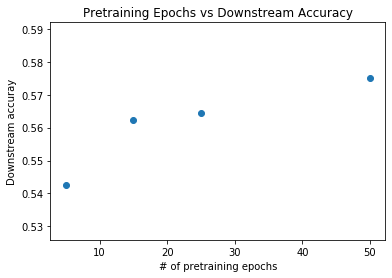

In [30]:
x =[5, 15, 25, 50]
y= [.5427, .5622, .5645, .5752]

# No pretraining, train subset, all train, train + unsup, train + unsup + val
plt.title("Pretraining Epochs vs Downstream Accuracy")
plt.xlabel("# of pretraining epochs")
plt.ylabel("Downstream accuray")
plt.scatter(x,y)